# SQL Test

### Imports and configurations

In [2]:
# Disable warnings
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
# Libraries
import mysql.connector
import pandas as pd

# MySQL Connection
import config_file
config = config_file

db = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.passwd,
    database = config.database)

cursor = db.cursor()

# Pandas format float decimal places
pd.options.display.float_format = '{:,.2f}'.format

# Load R magic
%load_ext rpy2.ipython

# R libraries
%R library(tidyverse)

### What are the 10 most expensive products in the company?

**Solution**: The top 10 expensive products are listed below. The list include items like Whisky, Champagne and others.

In [3]:
df = pd.read_sql('''SELECT PRODUCT_COD as Code,
                           PRODUCT_NAME as 'Product Description',
                           PRODUCT_VAL as Price
                    FROM data_product
                    ORDER BY PRODUCT_VAL DESC
                    LIMIT 10''',
                    db, index_col=["Code"])
df.index.name = None
df.columns.name = 'Code'
df

Code,Product Description,Price
301409,Whisky Escoces THE MACALLAN Ruby Garrafa 700ml...,741.99
176185,Whisky Escoces JOHNNIE WALKER Blue Label Garra...,735.90
315481,Cafeteira Expresso 3 CORACOES Tres Modo Vermelho,499.00
100280,Vinho Portugues Tinto Vintage QUINTA DO CRASTO...,445.90
320046,Escova Dental Eletrica ORAL B D34 Professional...,399.90
190817,Champagne Rose VEUVE CLICQUOT PONSARDIM Garraf...,366.90
153795,Champagne Frances Brut Imperial MOET Rose Garr...,359.90
311397,Conjunto de Panelas Allegra em Inox TRAMONTINA...,359.00
147706,Whisky Escoces CHIVAS REGAL 18 Anos Garrafa 750ml,329.90
154431,Champagne Frances Brut Imperial MOET & CHANDON...,315.90


### What sections do the 'BEBIDAS' and 'PADARIA' departments have?

**Solution**: Both 'BEBIDAS' and 'PADARIA' departments have four sections each, where one of the four sections receives the same name as its department.

In [4]:
df = pd.read_sql('''SELECT DISTINCT
                        SECTION_COD AS 'Section Code',
                        SECTION_NAME AS Section,
                        DEP_NAME AS Department,
                        DEP_COD AS 'Department Code'
                    FROM data_product
                    WHERE DEP_NAME = 'BEBIDAS'
                       OR DEP_NAME = 'PADARIA'
                    ORDER BY DEP_NAME''',
                    db, index_col = ['Section Code'])
df.index.name = None
df.columns.name = 'Section Code'
df

Section Code,Section,Department,Department Code
4,BEBIDAS,BEBIDAS,2
29,CERVEJAS,BEBIDAS,2
30,VINHOS,BEBIDAS,2
31,REFRESCOS,BEBIDAS,2
8,DOCES-E-SOBREMESAS,PADARIA,7
19,PADARIA,PADARIA,7
22,QUEIJOS-E-FRIOS,PADARIA,7
27,GESTANTE,PADARIA,7


### What was the total sale of products (in $) of each Business Area in the first quarter of 2019?

**Solution**: Business areas sold more than 80 million in the first quarter of 2019, except Posto, which sold just over 32 million.

In [5]:
df = pd.read_sql('''SELECT DSC.BUSINESS_CODE AS 'Business Code',
                           DSC.BUSINESS_NAME AS 'Business Area',
                           SUM(DSS.SALES_VALUE) AS 'Total Sales ($) - Q1/2019'
                    FROM data_store_cad as DSC,
                         data_store_sales AS DSS
                    WHERE QUARTER(DSS.DATE) = 1
                      AND YEAR(DSS.DATE) = 2019
                      AND DSC.STORE_CODE = DSS.STORE_CODE
                    GROUP BY DSC.BUSINESS_CODE, DSC.BUSINESS_NAME''',
                    db, index_col = ['Business Code'])
df.index.name = None
df.columns.name = 'Business Code'
df

Business Code,Business Area,Total Sales ($) - Q1/2019
1,Varejo,"81,032,347.65"
2,Proximidade,"80,171,122.80"
3,Posto,"32,072,326.40"
4,Farma,"81,776,691.73"
5,Atacado,"80,384,884.60"


# Cases

## 1) The Dev Team was tired of developing the same old queries just varying the filters accordingly to their boss demands.

As a new member of the crew, your mission now is to create a dynamic function, on the most flexible of ways, to produce queries and retrieve a dataframe based on three parameters:

* product_code: integer

* store_code: integer

* date: list of ISO-like strings

* Date e.g.

 * ['2019-01-01', '2019-01-31'] → Python

 * c('2019-01-01', '2019-01-31') → R

It should look like this my_data = retrieve_data(product_code, store_code, date)

Make your team proud!

Extra instructions: Retrieve all columns from table data_product_sales.

### Solution

In [6]:
# retrieve_data function definition
def retrieve_data(product_code, store_code, date):
    
    # Check correct data format for product_code, store_code and date
    try:
        # Specify the message error to be displayed, if error occurs.
        error = "Please insert a valid Product Code number. Message: "
        product_code = int(product_code)
        
        error = "Please insert a valid Store Code number. Message: "
        store_code = int(store_code)
        
        error = '''Please insert a string, list or tuple of formated date.
                Correct format: yyyy-mm-dd.'''
        if type(date) == list:
            date = tuple(i for i in date)
            error = "An error has occurred: "
        elif type(date) == str:
            date = (date,'')
            error = "An error has occurred: "
        elif type(date) == tuple:
            error = "An error has occurred: "
        else:
            return error
            
        # Try to execute Query
        try:
            cursor.execute("""
                SELECT * FROM data_product_sales
                WHERE PRODUCT_CODE = %(product_code)s
                  AND STORE_CODE = %(store_code)s
                  AND DATE IN {}
                """.format(date),
                {'product_code': product_code,
                 'store_code' : store_code})
            
            # Save query return into DataFrame
            df = pd.DataFrame(cursor.fetchall())
            
            # If DataFrame is not empty, get columns names and
            # applies them into the generated DataFrame.
            if df.empty:
                return "No results."
            else:
                # Return DataFrame
                df.columns = cursor.column_names
                return df
        
        # Display error message
        except Exception as e:
            print(error,e)

    except Exception as e:
        print(error,e)

Function characteristics:
* Checks the correct data type for all three parameters entries;
* Converts float into integer;
* Can receive either a string, list or tuple in "Date" type;
* Displays error messages if necessary.
* Prevents SQL Injection

An example of the function working:

In [7]:
# Example
product_code = 18
store_code = '1'
date = ['2019-01-01','2019-01-02','2019-01-04','2019-01-07','2000-01-07']
retrieve_data(product_code, store_code, date)

,STORE_CODE,PRODUCT_CODE,DATE,SALES_VALUE,SALES_QTY
0,1,18,2019-01-01,708.50,65
1,1,18,2019-01-02,1297.10,119
2,1,18,2019-01-04,1090.00,100
3,1,18,2019-01-07,654.00,60


In [8]:
# Example of error message:
product_code = 'text'
retrieve_data(product_code, store_code, date)

Please insert a valid Product Code number. Message:  invalid literal for int() with base 10: 'text'


## 2) A brand new client sent you two ready-to-go queries. Those are listed below:

Query 1:

In [9]:
# Execute the received ready-to-go queries and save results into DataFrames

data_store_cad = pd.read_sql('''

SELECT STORE_CODE,
       STORE_NAME,
       START_DATE,
       END_DATE,
       BUSINESS_NAME,
       BUSINESS_CODE
FROM data_store_cad

''', db, index_col = ['STORE_CODE'])

Query 2:

In [10]:
data_store_sales = pd.read_sql('''

SELECT STORE_CODE,
       DATE,
       SALES_VALUE,
       SALES_QTY
FROM data_store_sales
WHERE DATE BETWEEN '2019-01-01' AND '2019-12-31'

''', db, index_col = ['STORE_CODE'])

In addition, he gave you this set of instructions:

* You must not modify my queries!

* Please filter the period between this given range:

 * ['2019-10-01','2019-12-31']

### Solution

#### Data preparation

Before filtering the period on the given range, merge and data type conversion is performed in the obtained data. Then, a function that applies the wanted filter is defined. 

In [11]:
# Merge the two DataFrames generated from SQL queries into one.
data_store = pd.merge(data_store_cad,data_store_sales,
                      how='outer',
                      on=['STORE_CODE'])

# Convert Date data type into datetime
data_store['START_DATE'] = pd.to_datetime(data_store.START_DATE)
data_store['END_DATE'] = pd.to_datetime(data_store.END_DATE)
data_store['DATE'] = pd.to_datetime(data_store.DATE)

# Create function that returns TM by range of dates
def TM_Period(start,end):
    # Filter between range of dates, Sales Values and Quantities sum,
    # group by Store Name and Business
    tm = data_store[(data_store['DATE'] >= start) &
                    (data_store['DATE'] <= end)].groupby(
                    ['STORE_NAME',
                     'BUSINESS_NAME']
                    )[['SALES_VALUE',
                       'SALES_QTY']].sum().reset_index()
    # Calculate TM
    tm['TM'] = tm['SALES_VALUE'] / tm['SALES_QTY']
    
    # Define how the result should be displayed
    tm = tm[['STORE_NAME',
             'BUSINESS_NAME',
             'TM']].rename(
                    columns={'STORE_NAME': 'Loja',
                             'BUSINESS_NAME': 'Categoria'})
    return tm

#### TM filtered by period

After data is seted up, the section below calls the filter on the requested date and returns the TM by Store and Business.

In [12]:
# The range date filter can be easily changed in the function below
# if the consultation of a different period is needed in the future
TM_Period('2019-10-01','2019-12-31')

,Loja,Categoria,TM
0,Bahia,Atacado,15.39
1,Bangkok,Posto,13.67
2,Belem,Proximidade,15.37
3,Berlin,Proximidade,15.39
4,Buenos Aires,Atacado,15.39
5,Chicago,Varejo,15.53
6,Dubai,Atacado,15.39
7,Hong Kong,Farma,26.35
8,London,Farma,28.99
9,Madri,Farma,29.03


## 3) Building your own visualization

Create at least one chart using the table IMDB_movies. The code must be in R or Python, and you are free to use any libraries, data in the table and graphic format. Explain why you chose the visualization (or visualizations) you are submitting.

### Solution

**This analysis aims to better understand which factors favor the revenue of a movie.**

**Questions**:
* Is revenue related to metascore?
* Are some genres more profitable than others?

##### Data Preparation

In [13]:
# Collect data
IMDB_movies = pd.read_sql("SELECT * FROM IMDB_movies", db, index_col = ['Id'])

# Check Missing values and duplicates
print("Missing Values:\n", IMDB_movies.isnull().sum())
print("\nDuplicated Values: ",IMDB_movies.duplicated().sum())

Missing Values:
 Title                0
Genre                0
Director             0
Actors               0
Year                 0
Runtime              0
Rating               0
Votes                0
RevenueMillions    128
Metascore           64
dtype: int64

Duplicated Values:  0


**Note:** This section is written in R language.

'%R' and '%%R' allows R language to be interpreted in a Python notebook.

In [14]:
%R -i IMDB_movies
# Gets DataFrame variable from Python and stores it in R

In the next step, a new data frame is generated. The new data has the 'Genre' content splited in different rows and rows with null values ignored.

In [15]:
%%R
# Split multivalued genres names stored in 'Genre' column.
Genre_movies <- separate_rows(IMDB_movies,Genre,sep = ',') %>%
    filter(!is.na(Metascore)) %>%
    filter(!is.na(RevenueMillions))

#### Is metascore directly related to revenue? The higher the metascore, the higher the revenue?

##### Chart

R[write to console]: `geom_smooth()` using formula 'y ~ x'



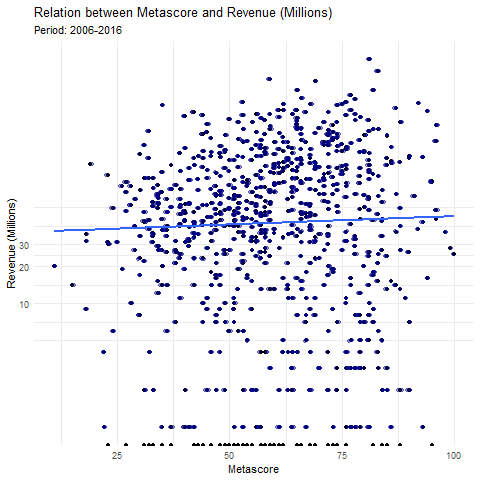

In [17]:
%%R

# Relation between Metascore and Revenue (Millions)
ggplot(Genre_movies,
        aes(x = Metascore,
            y = RevenueMillions)) +
        geom_point() +
        geom_jitter(color = "darkblue",
                    alpha = 0.4) +
        geom_smooth(method = 'lm',
                    se = FALSE) +
        scale_y_log10(breaks = c(10, 20, 30)) +
        labs(x = 'Metascore',
             y = 'Revenue (Millions)') +
        ggtitle('Relation between Metascore and Revenue (Millions)', 'Period: 2006-2016') +
        theme_minimal()

##### Conclusion

Analysing the way data is spread over the graph above, it is not possible to notice a strong correlation between metascore and revenue.

#### As metascore and revenue are not strongly related, is revenue related to genres instead?

##### Chart

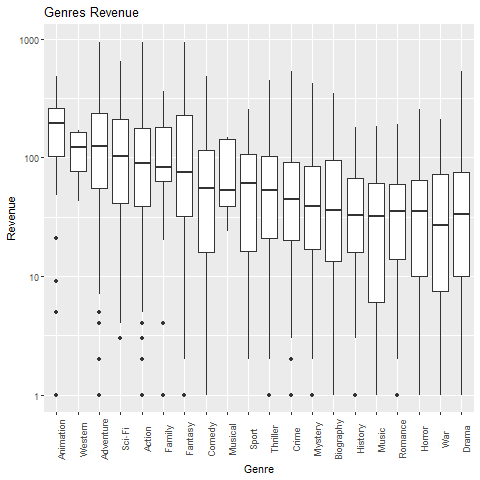

In [18]:
%%R

# Revenue Boxplot by Genre
ggplot(Genre_movies) + 
    geom_boxplot(
        aes(x = fct_reorder(.f = Genre,
                            .x = RevenueMillions,
                            .fun = median,
                            .desc = TRUE),
            y = RevenueMillions)) +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(x = 'Genre',
         y = 'Revenue') +
    ggtitle('Genres Revenue') +
    scale_y_log10()

##### Conclusion

In the chart above it is possible to notice a crescent order between revenue received by differents genres.


#### Since there are different revenues for different genres, would there be a stronger relation between metascore and revenue for some specific genres?

The first graph is replicated below, but this time it is separated by each genre.

R[write to console]: `geom_smooth()` using formula 'y ~ x'



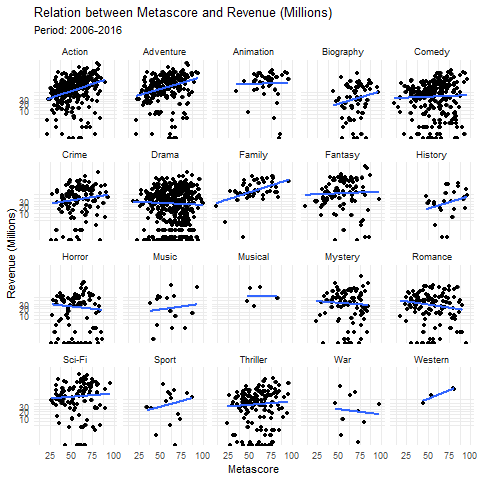

In [19]:
%%R

ggplot(Genre_movies,
        aes(x = Metascore,
            y = RevenueMillions)) +
        geom_point() +
        geom_jitter(alpha = 0.4) +
        geom_smooth(method = 'lm',
                    se = FALSE) +
        scale_y_log10(breaks = c(10, 20, 30)) +
        labs(x = 'Metascore',
             y = 'Revenue (Millions)') +
        ggtitle('Relation between Metascore and Revenue (Millions)',
                'Period: 2006-2016') +
        theme_minimal() +
        facet_wrap(~Genre)

##### Conclusion

The relation between revenue and metascore, for some genres, is stronger, weaker or even negative.
For genres 'Action', 'Adventure' and 'Family', for example, there's a better chance of having a good revenue if the metascore is also good. Otherwise, for 'Romance' genre it is more likely that a movie that generated high revenue has been poorly rated by critics.